In [1]:
import datetime
import numpy as np
import pandas as pd
import sqlalchemy as sa
import sqlalchemy.types
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from sqlalchemy.engine import reflection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
connection_string = 'DRIVER={ODBC Driver 17 for sql server};SERVER=BI-SQL;DATABASE=ZSDBillingDoc_BillingItm;UID=sa;PWD=1qazXSW@'

connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

engine = create_engine(connection_url,pool_size=10, max_overflow=20)

In [3]:
%%time
query = """
SELECT 
    LEFT([DOCDATE], 6) AS YearMonth,
    [CSTOMERCITY],
    [PLANTNAMETXT],
    SUM(
        CASE 
            WHEN [ITMWEIGHTUNI] = 'G' THEN [ITMNETWEIGHT] / 1000 
            ELSE [ITMNETWEIGHT] 
        END 
        * 
        CASE 
            WHEN [RETRNITMTYPE] = 'X' THEN -1 
            ELSE 1 
        END
    ) AS Calc_NETAMOUNT_Absolute_Final
FROM [ZSDBillingDoc_BillingItm].[dbo].[/BIC/OHZSDBILMHB]
WHERE [PLANTNAMETXT] = N'زرنگارپخش تهران'  
GROUP BY LEFT([DOCDATE], 6), [CSTOMERCITY], [PLANTNAMETXT]
"""

with engine.begin() as conn:
    df = pd.read_sql_query(sa.text(query), conn)


CPU times: total: 141 ms
Wall time: 7.97 s


In [4]:
conn.close()

In [5]:
df.to_csv(r"C:\Users\b-jafari.ZARMACARON\Notebooks\Data\Data LGBM Ton.csv")

In [6]:
df = pd.read_csv(r"C:\Users\b-jafari.ZARMACARON\Notebooks\Data\Data LGBM Ton.csv")

In [7]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 40)

In [9]:
df['YearMonth'] = pd.to_datetime(df['YearMonth'].astype(str), format='%Y%m')  
df['YearMonth'] = df['YearMonth'].dt.to_period('M')  


In [10]:
df

,YearMonth,CSTOMERCITY,PLANTNAMETXT,Calc_NETAMOUNT_Absolute_Final
0,2022-01,تهران-منطقه 4,زرنگارپخش تهران,69893.35
1,2021-08,لواسان,زرنگارپخش تهران,5763.33
2,2022-09,تهران-منطقه6,زرنگارپخش تهران,1025.07
3,2022-10,منطقه 6,زرنگارپخش تهران,591.86
4,2023-05,تهران-منطقه 17,زرنگارپخش تهران,9446.28
...,...,...,...,...
11369,2023-02,تهران _منطقه5,زرنگارپخش تهران,127.23
11370,2023-12,1,زرنگارپخش تهران,348.82
11371,2024-12,تهران- منطقه16,زرنگارپخش تهران,13.56
11372,2021-12,منطقه13,زرنگارپخش تهران,345.00


import numpy as np
import pandas as pd
import re

data = df.CSTOMERCITY.unique()

dg = pd.DataFrame(data, columns=['location'])

dg['location'] = dg['location'].str.replace(r'\s+', '', regex=True)

def convert_farsi_to_english(text):
    farsi_to_english_map = str.maketrans('۰۱۲۳۴۵۶۷۸۹', '0123456789')
    return text.translate(farsi_to_english_map)



def extract_region(location):
    
    location_english = convert_farsi_to_english(location)
    match = re.search(r'منطقه(\d+)', location_english)
    if match:
        region_number = int(match.group(1))  
        if region_number <= 22:
            return f"منطقه {region_number}"
    return None  




dg['region'] = dg['location'].apply(extract_region)

In [11]:
import pandas as pd
import re

# حذف مقادیر NaN برای جلوگیری از خطا
data = df['CSTOMERCITY'].dropna().unique()  

# تبدیل به DataFrame
dg = pd.DataFrame(data, columns=['location'])

# حذف فاصله‌های اضافی در نام شهر
dg['location'] = dg['location'].str.replace(r'\s+', '', regex=True)

# تابع تبدیل اعداد فارسی به انگلیسی
def convert_farsi_to_english(text):
    if pd.isna(text):  # بررسی مقدار NaN
        return text
    farsi_to_english_map = str.maketrans('۰۱۲۳۴۵۶۷۸۹', '0123456789')
    return text.translate(farsi_to_english_map)

# تابع استخراج عدد از متن و تبدیل آن به "منطقه X"
def extract_region(location):
    if pd.isna(location):  # بررسی مقدار NaN
        return None
    
    location_english = convert_farsi_to_english(location)
    match = re.search(r'(\d+)', location_english)  # جستجوی اولین عدد در متن
    
    if match:
        return f"منطقه {match.group(1)}"  # نمایش منطقه همراه با عدد استخراج‌شده
    
    return None  

# اعمال تابع استخراج منطقه
dg['region'] = dg['location'].apply(extract_region)

# نمایش ۵ سطر اول
print(dg.head())



        location    region
0   تهران-منطقه4   منطقه 4
1         لواسان      None
2   تهران-منطقه6   منطقه 6
3         منطقه6   منطقه 6
4  تهران-منطقه17  منطقه 17


In [12]:
dg.loc[dg['region']=='منطقه 04','region']='منطقه 4'

In [13]:
dg.loc[dg['location'].str.contains('کرج', na=False),'region']=None


In [14]:
dg=dg.drop_duplicates()

In [15]:
df['CSTOMERCITY'] = df['CSTOMERCITY'].str.replace(r'\s+', '', regex=True)

In [16]:
dff=df.merge(dg,left_on=['CSTOMERCITY'],right_on=['location'],how='left')




In [17]:
dff

,YearMonth,CSTOMERCITY,PLANTNAMETXT,Calc_NETAMOUNT_Absolute_Final,location,region
0,2022-01,تهران-منطقه4,زرنگارپخش تهران,69893.35,تهران-منطقه4,منطقه 4
1,2021-08,لواسان,زرنگارپخش تهران,5763.33,لواسان,None
2,2022-09,تهران-منطقه6,زرنگارپخش تهران,1025.07,تهران-منطقه6,منطقه 6
3,2022-10,منطقه6,زرنگارپخش تهران,591.86,منطقه6,منطقه 6
4,2023-05,تهران-منطقه17,زرنگارپخش تهران,9446.28,تهران-منطقه17,منطقه 17
...,...,...,...,...,...,...
11369,2023-02,تهران_منطقه5,زرنگارپخش تهران,127.23,تهران_منطقه5,منطقه 5
11370,2023-12,1,زرنگارپخش تهران,348.82,1,منطقه 1
11371,2024-12,تهران-منطقه16,زرنگارپخش تهران,13.56,تهران-منطقه16,منطقه 16
11372,2021-12,منطقه13,زرنگارپخش تهران,345.00,منطقه13,منطقه 13


In [18]:
dff.rename(columns={'Calc_NETAMOUNT_Absolute_Final':'Sale'},inplace=True)

In [19]:
dff=dff[~dff['region'].isna()]

In [20]:
dff=dff.groupby(['YearMonth','region']).agg({'Sale':np.sum}).reset_index()


In [21]:
def DateChanges(data):
    data['Year']=data['YearMonth'].dt.year
    data['month']=data['YearMonth'].dt.month

    min_year = data['Year'].min()
    max_year = data['Year'].max()
    
    data['Year_sin'] = np.sin(2 * np.pi * (data['Year'] - min_year) / (max_year - min_year))
    data['Year_cos'] = np.cos(2 * np.pi * (data['Year'] - min_year) / (max_year - min_year))

    data['Month_sin'] = np.sin(2 * np.pi * data['month'] / 12) 
    data['Month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

    

In [22]:
DateChanges(dff)

In [23]:
dff = pd.get_dummies(dff, columns = ['Year','month','region'], drop_first=False)

In [24]:
dff

,YearMonth,Sale,Year_sin,Year_cos,Month_sin,Month_cos,Year_2021,Year_2022,Year_2023,Year_2024,...,region_منطقه 3,region_منطقه 32,region_منطقه 33,region_منطقه 4,region_منطقه 45,region_منطقه 5,region_منطقه 6,region_منطقه 7,region_منطقه 8,region_منطقه 9
0,2021-06,7284.60,0.00,1.00,0.00,-1.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-06,1400.20,0.00,1.00,0.00,-1.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-06,3715.50,0.00,1.00,0.00,-1.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-06,6446.37,0.00,1.00,0.00,-1.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-06,2188.15,0.00,1.00,0.00,-1.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2025-03,2586.08,-0.00,1.00,1.00,0.00,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1162,2025-03,3237.69,-0.00,1.00,1.00,0.00,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1163,2025-03,3980.56,-0.00,1.00,1.00,0.00,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1164,2025-03,524.92,-0.00,1.00,1.00,0.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
dfff=dff

In [26]:
sorted(dfff.YearMonth.unique())

[Period('2021-06', 'M'),
 Period('2021-07', 'M'),
 Period('2021-08', 'M'),
 Period('2021-09', 'M'),
 Period('2021-10', 'M'),
 Period('2021-11', 'M'),
 Period('2021-12', 'M'),
 Period('2022-01', 'M'),
 Period('2022-02', 'M'),
 Period('2022-03', 'M'),
 Period('2022-04', 'M'),
 Period('2022-05', 'M'),
 Period('2022-06', 'M'),
 Period('2022-07', 'M'),
 Period('2022-08', 'M'),
 Period('2022-09', 'M'),
 Period('2022-10', 'M'),
 Period('2022-11', 'M'),
 Period('2022-12', 'M'),
 Period('2023-01', 'M'),
 Period('2023-02', 'M'),
 Period('2023-03', 'M'),
 Period('2023-04', 'M'),
 Period('2023-05', 'M'),
 Period('2023-06', 'M'),
 Period('2023-07', 'M'),
 Period('2023-08', 'M'),
 Period('2023-09', 'M'),
 Period('2023-10', 'M'),
 Period('2023-11', 'M'),
 Period('2023-12', 'M'),
 Period('2024-01', 'M'),
 Period('2024-02', 'M'),
 Period('2024-03', 'M'),
 Period('2024-04', 'M'),
 Period('2024-05', 'M'),
 Period('2024-06', 'M'),
 Period('2024-07', 'M'),
 Period('2024-08', 'M'),
 Period('2024-09', 'M'),


In [27]:
dft=dfff[dfff['YearMonth']==pd.Period('2024-09')]
dfff=dfff[dfff['YearMonth']< pd.Period('2024-09')]

In [28]:
dz=dft

In [29]:
def changeType(data):
    data.loc[:,['YearMonth']]=data.loc[:,['YearMonth']].astype('category')

In [30]:
changeType(dfff)
changeType(dft)

C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_26216\3704351169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,['YearMonth']]=data.loc[:,['YearMonth']].astype('category')
C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_26216\3704351169.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,['YearMonth']]=data.loc[:,['YearMonth']].astype('category')
C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_26216\3704351169.py:2: SettingWithCopyWarning: 
A value is trying to 

In [31]:
dfff.drop(['YearMonth'],axis=1,inplace=True)
dftt=dft.drop(['YearMonth'],axis=1)

C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_26216\3047849694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfff.drop(['YearMonth'],axis=1,inplace=True)


In [32]:
dftt

,Sale,Year_sin,Year_cos,Month_sin,Month_cos,Year_2021,Year_2022,Year_2023,Year_2024,Year_2025,...,region_منطقه 3,region_منطقه 32,region_منطقه 33,region_منطقه 4,region_منطقه 45,region_منطقه 5,region_منطقه 6,region_منطقه 7,region_منطقه 8,region_منطقه 9
993,22400.21,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
994,12312.42,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
995,54471.84,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
996,183927.76,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
997,18256.85,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
998,17132.51,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
999,22649.56,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1000,8582.12,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1001,11100.49,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1002,3645.03,-1.00,-0.00,-1.00,-0.00,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X =dfff.drop(columns=['Sale'])
y = dfff['Sale']

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np


def objective(trial):
    # پارامترهای قابل تنظیم با بیشترین بازه‌ها
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 31, 1024),  
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),  
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 20),  
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 50), 
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0), 
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),  
        'random_state': 42
    }
    
    model = LGBMRegressor(**params)
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')
    
    y_pred = model.predict(X_val)
    y_pred = np.clip(y_pred, 0, None)
    
    rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
    return rmsle


In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import numpy as np
import optuna
from lightgbm import LGBMRegressor


def objective(trial):
    # پارامترهای قابل تنظیم با بیشترین بازه‌ها
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 31, 1024),  
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),  
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 20),  
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 50), 
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0), 
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),  
        'random_state': 42
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # ایجاد K-Fold Splitter با 5 تقسیم
    
    rmsle_scores = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # جلوگیری از مقادیر منفی در y_val
        y_val = np.maximum(0, y_val)
        
        model = LGBMRegressor(**params)
        
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')
        
        y_pred = model.predict(X_val)
        y_pred = np.clip(y_pred, 0, None)  # جلوگیری از پیش‌بینی مقادیر منفی
        
        # محاسبه RMSLE
        rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
        rmsle_scores.append(rmsle)
    
    return np.mean(rmsle_scores)



In [37]:
study = optuna.create_study(direction='minimize')  # هدف کاهش خطا است
study.optimize(objective, n_trials=50)  # 

[I 2025-03-03 09:21:04,899] A new study created in memory with name: no-name-7f6f6324-57aa-4db3-a0af-1d23b5f23df8


[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.9121101796160052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9121101796160052
[LightGBM] [Warning] lambda_l1 is set=3.1127161850514717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1127161850514717
[LightGBM] [Warning] lambda_l2 is set=0.029731532182446507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029731532182446507
[LightGBM] [Warning] bagging_fraction is set=0.7100959753496807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100959753496807
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in

[I 2025-03-03 09:21:05,278] Trial 0 finished with value: 2.27235863089878 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 755, 'learning_rate': 0.1980726004000471, 'feature_fraction': 0.9121101796160052, 'bagging_fraction': 0.7100959753496807, 'bagging_freq': 12, 'min_data_in_leaf': 126, 'max_depth': 16, 'lambda_l1': 3.1127161850514717, 'lambda_l2': 0.029731532182446507}. Best is trial 0 with value: 2.27235863089878.


[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.9121101796160052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9121101796160052
[LightGBM] [Warning] lambda_l1 is set=3.1127161850514717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1127161850514717
[LightGBM] [Warning] lambda_l2 is set=0.029731532182446507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029731532182446507
[LightGBM] [Warning] bagging_fraction is set=0.7100959753496807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100959753496807
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.9121101796160052, colsa

[I 2025-03-03 09:21:05,548] Trial 1 finished with value: 2.2517241958145897 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 365, 'learning_rate': 0.29472603612744996, 'feature_fraction': 0.7368186560918399, 'bagging_fraction': 0.7999990563871481, 'bagging_freq': 10, 'min_data_in_leaf': 169, 'max_depth': 28, 'lambda_l1': 2.5401882454091, 'lambda_l2': 7.043594986596293}. Best is trial 1 with value: 2.2517241958145897.


[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=169
[LightGBM] [Warning] feature_fraction is set=0.7368186560918399, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7368186560918399
[LightGBM] [Warning] lambda_l1 is set=2.5401882454091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5401882454091
[LightGBM] [Warning] lambda_l2 is set=7.043594986596293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.043594986596293
[LightGBM] [Warning] bagging_fraction is set=0.7999990563871481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7999990563871481
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=169
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.7930903774457885, colsample_bytree=1.0 will be ignored. Current value: feature_fr

[I 2025-03-03 09:21:05,950] Trial 2 finished with value: 2.2589245769969484 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 687, 'learning_rate': 0.16916813623870547, 'feature_fraction': 0.7930903774457885, 'bagging_fraction': 0.6499340845376284, 'bagging_freq': 5, 'min_data_in_leaf': 37, 'max_depth': 13, 'lambda_l1': 3.094595833832293, 'lambda_l2': 2.939171787757017}. Best is trial 1 with value: 2.2517241958145897.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:06,264] Trial 3 finished with value: 2.2418585800416335 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 470, 'learning_rate': 0.4961422052671408, 'feature_fraction': 0.9522005533698725, 'bagging_fraction': 0.9138823205170297, 'bagging_freq': 15, 'min_data_in_leaf': 84, 'max_depth': 10, 'lambda_l1': 1.8719420486476213, 'lambda_l2': 3.129204155471225}. Best is trial 3 with value: 2.2418585800416335.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.9522005533698725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9522005533698725
[LightGBM] [Warning] lambda_l1 is set=1.8719420486476213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8719420486476213
[LightGBM] [Warning] lambda_l2 is set=3.129204155471225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.129204155471225
[LightGBM] [Warning] bagging_fraction is set=0.9138823205170297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9138823205170297
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 26344.770369
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:06,674] Trial 4 finished with value: 2.24950623965251 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 1002, 'learning_rate': 0.23393715613196206, 'feature_fraction': 0.8122767358507618, 'bagging_fraction': 0.9027196640410813, 'bagging_freq': 9, 'min_data_in_leaf': 50, 'max_depth': 27, 'lambda_l1': 8.459809491712901, 'lambda_l2': 8.989535907617306}. Best is trial 3 with value: 2.2418585800416335.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8122767358507618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8122767358507618
[LightGBM] [Warning] lambda_l1 is set=8.459809491712901, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.459809491712901
[LightGBM] [Warning] lambda_l2 is set=8.989535907617306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.989535907617306
[LightGBM] [Warning] bagging_fraction is set=0.9027196640410813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9027196640410813
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[Lig

[I 2025-03-03 09:21:06,960] Trial 5 finished with value: 2.48045632266339 and parameters: {'boosting_type': 'dart', 'num_leaves': 664, 'learning_rate': 0.10548038140588109, 'feature_fraction': 0.827755854523244, 'bagging_fraction': 0.988722458430501, 'bagging_freq': 3, 'min_data_in_leaf': 174, 'max_depth': 32, 'lambda_l1': 2.4765461003443843, 'lambda_l2': 2.0932242491808486}. Best is trial 3 with value: 2.2418585800416335.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=174, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=174
[LightGBM] [Warning] feature_fraction is set=0.827755854523244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.827755854523244
[LightGBM] [Warning] lambda_l1 is set=2.4765461003443843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4765461003443843
[LightGBM] [Warning] lambda_l2 is set=2.0932242491808486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0932242491808486
[LightGBM] [Warning] bagging_fraction is set=0.988722458430501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988722458430501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_c

[I 2025-03-03 09:21:07,198] Trial 6 finished with value: 3.333568932639288 and parameters: {'boosting_type': 'dart', 'num_leaves': 275, 'learning_rate': 0.21859503698970087, 'feature_fraction': 0.9439418792848665, 'bagging_fraction': 0.9988060773666756, 'bagging_freq': 11, 'min_data_in_leaf': 198, 'max_depth': 37, 'lambda_l1': 5.5598674125429906, 'lambda_l2': 1.9699321825592198}. Best is trial 3 with value: 2.2418585800416335.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:07,661] Trial 7 finished with value: 2.4840143457423878 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'learning_rate': 0.41805218270466976, 'feature_fraction': 0.8254446478686905, 'bagging_fraction': 0.7543010217296511, 'bagging_freq': 19, 'min_data_in_leaf': 29, 'max_depth': 26, 'lambda_l1': 8.44196601352113, 'lambda_l2': 5.227873381844228}. Best is trial 3 with value: 2.2418585800416335.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.8254446478686905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8254446478686905
[LightGBM] [Warning] lambda_l1 is set=8.44196601352113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.44196601352113
[LightGBM] [Warning] lambda_l2 is set=5.227873381844228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.227873381844228
[LightGBM] [Warning] bagging_fraction is set=0.7543010217296511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7543010217296511
[LightGBM] [Warning] bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8557764741272759, colsample_bytree=1.

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8557764741272759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8557764741272759
[LightGBM] [Warning] lambda_l1 is set=0.19787941800887832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19787941800887832
[LightGBM] [Warning] lambda_l2 is set=0.5903635820898123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5903635820898123
[LightGBM] [Warning] bagging_fraction is set=0.7010406412977267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7010406412977267
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:08,579] Trial 8 finished with value: 1.7415869286467447 and parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'learning_rate': 0.02471141863526785, 'feature_fraction': 0.8557764741272759, 'bagging_fraction': 0.7010406412977267, 'bagging_freq': 17, 'min_data_in_leaf': 12, 'max_depth': 34, 'lambda_l1': 0.19787941800887832, 'lambda_l2': 0.5903635820898123}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:08,906] Trial 9 finished with value: 2.266723496960164 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 690, 'learning_rate': 0.031449392349813386, 'feature_fraction': 0.8521228271832689, 'bagging_fraction': 0.5529408315784252, 'bagging_freq': 1, 'min_data_in_leaf': 61, 'max_depth': 18, 'lambda_l1': 8.292110276714851, 'lambda_l2': 4.979445955140585}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.8521228271832689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8521228271832689
[LightGBM] [Warning] lambda_l1 is set=8.292110276714851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.292110276714851
[LightGBM] [Warning] lambda_l2 is set=4.979445955140585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.979445955140585
[LightGBM] [Warning] bagging_fraction is set=0.5529408315784252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5529408315784252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.8521228271832689, colsample_bytree=1.

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8887465706768444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8887465706768444
[LightGBM] [Warning] lambda_l1 is set=0.20991847946710696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20991847946710696
[LightGBM] [Warning] lambda_l2 is set=0.1422011056386916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1422011056386916
[LightGBM] [Warning] bagging_fraction is set=0.5019536366741173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5019536366741173
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:09,778] Trial 10 finished with value: 1.8576026682976583 and parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'learning_rate': 0.013400166857658801, 'feature_fraction': 0.8887465706768444, 'bagging_fraction': 0.5019536366741173, 'bagging_freq': 20, 'min_data_in_leaf': 12, 'max_depth': 48, 'lambda_l1': 0.20991847946710696, 'lambda_l2': 0.1422011056386916}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8781323872739585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781323872739585
[LightGBM] [Warning] lambda_l1 is set=0.3249756202863182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3249756202863182
[LightGBM] [Warning] lambda_l2 is set=0.22024349518278163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22024349518278163
[LightGBM] [Warning] bagging_fraction is set=0.5247727084210253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5247727084210253
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8781323872739585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8781323872739585
[LightGBM] [Warning] lambda_l1 is set=0.3249756202863182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3249756202863182
[LightGBM] [Warning] lambda_l2 is set=0.22024349518278163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22024349518278163
[LightGBM] [Warning] bagging_fraction is set=0.5247727084210253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5247727084210253
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8781323872739585, colsample_b

[I 2025-03-03 09:21:10,650] Trial 11 finished with value: 1.8694254900202414 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'learning_rate': 0.010053956248726814, 'feature_fraction': 0.8781323872739585, 'bagging_fraction': 0.5247727084210253, 'bagging_freq': 20, 'min_data_in_leaf': 12, 'max_depth': 49, 'lambda_l1': 0.3249756202863182, 'lambda_l2': 0.22024349518278163}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.9058652849429648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9058652849429648
[LightGBM] [Warning] lambda_l1 is set=0.08906238218401949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08906238218401949
[LightGBM] [Warning] lambda_l2 is set=1.1535222149502407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1535222149502407
[LightGBM] [Warning] bagging_fraction is set=0.6115404834600113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6115404834600113
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.9058652849429648, colsample_bytree=1.0 will be ignored. Current value: feature_fr

[I 2025-03-03 09:21:11,463] Trial 12 finished with value: 1.7625906991188844 and parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'learning_rate': 0.01999672524039052, 'feature_fraction': 0.9058652849429648, 'bagging_fraction': 0.6115404834600113, 'bagging_freq': 16, 'min_data_in_leaf': 11, 'max_depth': 47, 'lambda_l1': 0.08906238218401949, 'lambda_l2': 1.1535222149502407}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:11,720] Trial 13 finished with value: 2.137852801888312 and parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'learning_rate': 0.02640644724234353, 'feature_fraction': 0.9869699000760989, 'bagging_fraction': 0.6530828889302955, 'bagging_freq': 16, 'min_data_in_leaf': 101, 'max_depth': 40, 'lambda_l1': 4.954287257786524, 'lambda_l2': 1.3639652065653454}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] feature_fraction is set=0.9869699000760989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9869699000760989
[LightGBM] [Warning] lambda_l1 is set=4.954287257786524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.954287257786524
[LightGBM] [Warning] lambda_l2 is set=1.3639652065653454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3639652065653454
[LightGBM] [Warning] bagging_fraction is set=0.6530828889302955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6530828889302955
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7643814600840781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7643814600840781
[LightGBM] [Warning] lambda_l1 is set=1.0333248945682802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0333248945682802
[LightGBM] [Warning] lambda_l2 is set=4.262907406019753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.262907406019753
[LightGBM] [Warning] bagging_fraction is set=0.6289330399805585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6289330399805585
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2025-03-03 09:21:12,017] Trial 14 finished with value: 7.301142141516598 and parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'learning_rate': 0.04092239292602776, 'feature_fraction': 0.7643814600840781, 'bagging_fraction': 0.6289330399805585, 'bagging_freq': 16, 'min_data_in_leaf': 70, 'max_depth': 42, 'lambda_l1': 1.0333248945682802, 'lambda_l2': 4.262907406019753}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[I 2025-03-03 09:21:12,272] Trial 15 finished with value: 9.408905917570905 and parameters: {'boosting_type': 'dart', 'num_leaves': 422, 'learning_rate': 0.019952019900887217, 'feature_fraction': 0.9125147627527609, 'bagging_fraction': 0.6062881931890743, 'bagging_freq': 14, 'min_data_in_leaf': 124, 'max_depth': 44, 'lambda_l1': 4.598103108434168, 'lambda_l2': 6.733584760811062}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.9125147627527609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9125147627527609
[LightGBM] [Warning] lambda_l1 is set=4.598103108434168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.598103108434168
[LightGBM] [Warning] lambda_l2 is set=6.733584760811062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.733584760811062
[LightGBM] [Warning] bagging_fraction is set=0.6062881931890743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6062881931890743
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:12,707] Trial 16 finished with value: 2.195222667605564 and parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'learning_rate': 0.05894268577709371, 'feature_fraction': 0.8667700762652487, 'bagging_fraction': 0.7209813547277093, 'bagging_freq': 18, 'min_data_in_leaf': 35, 'max_depth': 34, 'lambda_l1': 6.723940662870625, 'lambda_l2': 1.247047294155219}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:13,033] Trial 17 finished with value: 3.5263967578771434 and parameters: {'boosting_type': 'dart', 'num_leaves': 300, 'learning_rate': 0.01780865615178823, 'feature_fraction': 0.7010312848175331, 'bagging_fraction': 0.8031363390571349, 'bagging_freq': 7, 'min_data_in_leaf': 81, 'max_depth': 21, 'lambda_l1': 1.4277116947194899, 'lambda_l2': 3.3004475138354743}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:13,441] Trial 18 finished with value: 2.131991168533749 and parameters: {'boosting_type': 'dart', 'num_leaves': 548, 'learning_rate': 0.05483624535190049, 'feature_fraction': 0.9856185685680874, 'bagging_fraction': 0.5758042715862217, 'bagging_freq': 13, 'min_data_in_leaf': 21, 'max_depth': 5, 'lambda_l1': 0.04639313406082429, 'lambda_l2': 1.1790447937686341}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:13,796] Trial 19 finished with value: 6.258155650021168 and parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'learning_rate': 0.10935151465814817, 'feature_fraction': 0.9113175745359635, 'bagging_fraction': 0.6898749925429835, 'bagging_freq': 18, 'min_data_in_leaf': 47, 'max_depth': 45, 'lambda_l1': 4.186044985813697, 'lambda_l2': 4.091543918751032}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.9113175745359635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9113175745359635
[LightGBM] [Warning] lambda_l1 is set=4.186044985813697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.186044985813697
[LightGBM] [Warning] lambda_l2 is set=4.091543918751032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.091543918751032
[LightGBM] [Warning] bagging_fraction is set=0.6898749925429835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6898749925429835
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] feature_fraction is set=0.9487301566793578, colsample_bytre

[I 2025-03-03 09:21:14,076] Trial 20 finished with value: 5.9023008113955395 and parameters: {'boosting_type': 'dart', 'num_leaves': 941, 'learning_rate': 0.0337038996855948, 'feature_fraction': 0.9487301566793578, 'bagging_fraction': 0.7829057545259909, 'bagging_freq': 17, 'min_data_in_leaf': 107, 'max_depth': 36, 'lambda_l1': 9.47440913096198, 'lambda_l2': 6.555645618122425}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] feature_fraction is set=0.9487301566793578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9487301566793578
[LightGBM] [Warning] lambda_l1 is set=9.47440913096198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.47440913096198
[LightGBM] [Warning] lambda_l2 is set=6.555645618122425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.555645618122425
[LightGBM] [Warning] bagging_fraction is set=0.7829057545259909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7829057545259909
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:14,774] Trial 21 finished with value: 1.8440973782223977 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'learning_rate': 0.011476639574279, 'feature_fraction': 0.8813541204467579, 'bagging_fraction': 0.5281792526905984, 'bagging_freq': 20, 'min_data_in_leaf': 10, 'max_depth': 50, 'lambda_l1': 0.7090609327971871, 'lambda_l2': 0.5504668180367801}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.8908495373107874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8908495373107874
[LightGBM] [Warning] lambda_l1 is set=0.9403348801223799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9403348801223799
[LightGBM] [Warning] lambda_l2 is set=2.1903652001964047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1903652001964047
[LightGBM] [Warning] bagging_fraction is set=0.5860775071575429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5860775071575429
[LightGBM] [Warning] bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.8908495373107874, colsample_bytree=1.0 will be ignored. Current value: feature_fr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:15,468] Trial 22 finished with value: 1.862591632159179 and parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'learning_rate': 0.010902946143503194, 'feature_fraction': 0.8908495373107874, 'bagging_fraction': 0.5860775071575429, 'bagging_freq': 17, 'min_data_in_leaf': 11, 'max_depth': 50, 'lambda_l1': 0.9403348801223799, 'lambda_l2': 2.1903652001964047}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.8908495373107874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8908495373107874
[LightGBM] [Warning] lambda_l1 is set=0.9403348801223799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.94033488

[I 2025-03-03 09:21:15,778] Trial 23 finished with value: 2.1062409224741576 and parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'learning_rate': 0.0174253711513383, 'feature_fraction': 0.862659235382612, 'bagging_fraction': 0.5435858130073945, 'bagging_freq': 14, 'min_data_in_leaf': 46, 'max_depth': 39, 'lambda_l1': 1.5595408837070022, 'lambda_l2': 1.0206559793609298}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:16,259] Trial 24 finished with value: 2.0827864099990343 and parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'learning_rate': 0.02157242180993324, 'feature_fraction': 0.9263444395038285, 'bagging_fraction': 0.6703348391672436, 'bagging_freq': 20, 'min_data_in_leaf': 25, 'max_depth': 46, 'lambda_l1': 0.7648019833506012, 'lambda_l2': 0.7398044490531738}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.8382633347745152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8382633347745152
[LightGBM] [Warning] lambda_l1 is set=3.687187042508187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.687187042508187
[LightGBM] [Warning] lambda_l2 is set=2.2883881883228465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2883881883228465
[LightGBM] [Warning] bagging_fraction is set=0.6115894130999324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6115894130999324
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


[I 2025-03-03 09:21:16,605] Trial 25 finished with value: 2.09287198396498 and parameters: {'boosting_type': 'dart', 'num_leaves': 327, 'learning_rate': 0.014082778801572892, 'feature_fraction': 0.8382633347745152, 'bagging_fraction': 0.6115894130999324, 'bagging_freq': 18, 'min_data_in_leaf': 65, 'max_depth': 31, 'lambda_l1': 3.687187042508187, 'lambda_l2': 2.2883881883228465}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.8382633347745152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8382633347745152
[LightGBM] [Warning] lambda_l1 is set=3.687187042

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7953041028478183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7953041028478183
[LightGBM] [Warning] lambda_l1 is set=2.0833941400410314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0833941400410314
[LightGBM] [Warning] lambda_l2 is set=9.387146655118045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.387146655118045
[LightGBM] [Warning] bagging_fraction is set=0.5629755082458068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5629755082458068
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[Ligh

[I 2025-03-03 09:21:16,943] Trial 26 finished with value: 8.481501541545175 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'learning_rate': 0.042955144046490444, 'feature_fraction': 0.7953041028478183, 'bagging_fraction': 0.5629755082458068, 'bagging_freq': 15, 'min_data_in_leaf': 28, 'max_depth': 42, 'lambda_l1': 2.0833941400410314, 'lambda_l2': 9.387146655118045}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] feature_fraction is set=0.8889024507968545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8889024507968545
[LightGBM] [Warning] lambda_l1 is set=0.8325583714786431, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8325583714786431
[LightGBM] [Warning] lambda_l2 is set=1.6334604381417162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6334604381417162
[LightGBM] [Warning] bagging_fraction is set=0.514644613443338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.514644613443338
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2025-03-03 09:21:17,245] Trial 27 finished with value: 2.1326588779900075 and parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'learning_rate': 0.025882112019304467, 'feature_fraction': 0.8889024507968545, 'bagging_fraction': 0.514644613443338, 'bagging_freq': 16, 'min_data_in_leaf': 53, 'max_depth': 50, 'lambda_l1': 0.8325583714786431, 'lambda_l2': 1.6334604381417162}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.9660219488913097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9660219488913097
[LightGBM] [Warning] lambda_l1 is set=6.650446910

[I 2025-03-03 09:21:17,657] Trial 28 finished with value: 2.0937783096408107 and parameters: {'boosting_type': 'dart', 'num_leaves': 386, 'learning_rate': 0.014141395915087689, 'feature_fraction': 0.9660219488913097, 'bagging_fraction': 0.8376153027069398, 'bagging_freq': 19, 'min_data_in_leaf': 37, 'max_depth': 46, 'lambda_l1': 6.650446910539849, 'lambda_l2': 0.6554710936891168}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:17,943] Trial 29 finished with value: 2.1292535097896743 and parameters: {'boosting_type': 'dart', 'num_leaves': 848, 'learning_rate': 0.022805353229534416, 'feature_fraction': 0.9156853093335855, 'bagging_fraction': 0.713973309009466, 'bagging_freq': 12, 'min_data_in_leaf': 144, 'max_depth': 23, 'lambda_l1': 3.1626041324097858, 'lambda_l2': 0.28622637523730854}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] feature_fraction is set=0.9156853093335855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9156853093335855
[LightGBM] [Warning] lambda_l1 is set=3.1626041324097858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1626041324097858
[LightGBM] [Warning] lambda_l2 is set=0.28622637523730854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28622637523730854
[LightGBM] [Warning] bagging_fraction is set=0.713973309009466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.713973309009466
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.8498267008650168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8498267008650168
[LightGBM] [Warning] lambda_l1 is set=0.0714739747548655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0714739747548655
[LightGBM] [Warning] lambda_l2 is set=2.6032921278830674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6032921278830674
[LightGBM] [Warning] bagging_fraction is set=0.747124364333343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.747124364333343
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.8498267008650168, colsample_bytree=

[I 2025-03-03 09:21:18,568] Trial 30 finished with value: 1.7919454916881565 and parameters: {'boosting_type': 'dart', 'num_leaves': 517, 'learning_rate': 0.08288073781863126, 'feature_fraction': 0.8498267008650168, 'bagging_fraction': 0.747124364333343, 'bagging_freq': 8, 'min_data_in_leaf': 21, 'max_depth': 42, 'lambda_l1': 0.0714739747548655, 'lambda_l2': 2.6032921278830674}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.849826

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:19,291] Trial 31 finished with value: 1.804912247250968 and parameters: {'boosting_type': 'dart', 'num_leaves': 592, 'learning_rate': 0.10853474029995776, 'feature_fraction': 0.8529281341686767, 'bagging_fraction': 0.7455243923511112, 'bagging_freq': 8, 'min_data_in_leaf': 10, 'max_depth': 41, 'lambda_l1': 0.3049611938237638, 'lambda_l2': 2.7025016869591942}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8529281341686767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8529281341686767
[LightGBM] [Warning] lambda_l1 is set=0.3049611938237638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3049611938237638
[LightGBM] [Warning] lambda_l2 is set=2.7025016869591942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7025016869591942
[LightGBM] [Warning] bagging_fraction is set=0.7455243923511112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7455243923511112
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:19,926] Trial 32 finished with value: 1.9676232297239125 and parameters: {'boosting_type': 'dart', 'num_leaves': 571, 'learning_rate': 0.12950380588382934, 'feature_fraction': 0.8481477423873921, 'bagging_fraction': 0.7449500130773634, 'bagging_freq': 8, 'min_data_in_leaf': 22, 'max_depth': 39, 'lambda_l1': 1.3991159750575146, 'lambda_l2': 2.8162608519070385}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:20,226] Trial 33 finished with value: 5.346061331943387 and parameters: {'boosting_type': 'dart', 'num_leaves': 613, 'learning_rate': 0.07827550112360167, 'feature_fraction': 0.8003278710605713, 'bagging_fraction': 0.8480281373804356, 'bagging_freq': 6, 'min_data_in_leaf': 41, 'max_depth': 42, 'lambda_l1': 0.009076583616635409, 'lambda_l2': 3.5793896290206115}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.8003278710605713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8003278710605713
[LightGBM] [Warning] lambda_l1 is set=0.009076583616635409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009076583616635409
[LightGBM] [Warning] lambda_l2 is set=3.5793896290206115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5793896290206115
[LightGBM] [Warning] bagging_fraction is set=0.8480281373804356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8480281373804356
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.8003278710605713, colsample_b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:20,658] Trial 34 finished with value: 2.244056315215963 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 471, 'learning_rate': 0.08441331981492495, 'feature_fraction': 0.7592122938950838, 'bagging_fraction': 0.6859612889686496, 'bagging_freq': 10, 'min_data_in_leaf': 24, 'max_depth': 35, 'lambda_l1': 2.394205839193077, 'lambda_l2': 2.656307706034293}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.8225803207703195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8225803207703195
[LightGBM] [Warning] lambda_l1 is set=3.0632855038076476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0632855038076476
[LightGBM] [Warning] lambda_l2 is set=3.9944397665288376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9944397665288376
[LightGBM] [Warning] bagging_fraction is set=0.7555101052434785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7555101052434785
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2025-03-03 09:21:21,017] Trial 35 finished with value: 2.259696344554513 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 763, 'learning_rate': 0.061549680880155076, 'feature_fraction': 0.8225803207703195, 'bagging_fraction': 0.7555101052434785, 'bagging_freq': 5, 'min_data_in_leaf': 34, 'max_depth': 32, 'lambda_l1': 3.0632855038076476, 'lambda_l2': 3.9944397665288376}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:21,611] Trial 36 finished with value: 1.9521327184820412 and parameters: {'boosting_type': 'dart', 'num_leaves': 785, 'learning_rate': 0.15547447670830214, 'feature_fraction': 0.7759255729925283, 'bagging_fraction': 0.7856471751539258, 'bagging_freq': 9, 'min_data_in_leaf': 19, 'max_depth': 30, 'lambda_l1': 1.5525422902416879, 'lambda_l2': 1.6974880282824338}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:21,981] Trial 37 finished with value: 6.165719473806712 and parameters: {'boosting_type': 'dart', 'num_leaves': 500, 'learning_rate': 0.10073049760786977, 'feature_fraction': 0.8434001367114289, 'bagging_fraction': 0.822029177314812, 'bagging_freq': 11, 'min_data_in_leaf': 54, 'max_depth': 38, 'lambda_l1': 1.9886150802904787, 'lambda_l2': 5.307790963363472}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:22,242] Trial 38 finished with value: 2.265608754859079 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 619, 'learning_rate': 0.04786600387264895, 'feature_fraction': 0.8646761989788748, 'bagging_fraction': 0.8798676239160925, 'bagging_freq': 8, 'min_data_in_leaf': 79, 'max_depth': 43, 'lambda_l1': 0.48589990751147694, 'lambda_l2': 2.5919076884704726}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:22,509] Trial 39 finished with value: 6.154751260210046 and parameters: {'boosting_type': 'dart', 'num_leaves': 397, 'learning_rate': 0.2863270462455452, 'feature_fraction': 0.8144705920518734, 'bagging_fraction': 0.7293284024657264, 'bagging_freq': 4, 'min_data_in_leaf': 165, 'max_depth': 34, 'lambda_l1': 2.7771929092501835, 'lambda_l2': 4.74084314062468}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] feature_fraction is set=0.8144705920518734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8144705920518734
[LightGBM] [Warning] lambda_l1 is set=2.7771929092501835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7771929092501835
[LightGBM] [Warning] lambda_l2 is set=4.74084314062468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.74084314062468
[LightGBM] [Warning] bagging_fraction is set=0.7293284024657264, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7293284024657264
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=165, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=165
[LightGBM] [Warning] feature_fraction is set=0.8144705920518734, colsample_bytre

[I 2025-03-03 09:21:22,733] Trial 40 finished with value: 2.2678869369395716 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 709, 'learning_rate': 0.18700022206194591, 'feature_fraction': 0.9308839282574414, 'bagging_fraction': 0.6477626008697666, 'bagging_freq': 12, 'min_data_in_leaf': 97, 'max_depth': 47, 'lambda_l1': 1.1575284473901715, 'lambda_l2': 5.788568333638217}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l1 is set=0.4941583122818687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4941583122818687
[LightGBM] [Warning] lambda_l2 is set=0.8083467363953025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8083467363953025
[LightGBM] [Warning] bagging_fraction is set=0.6954015117873963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6954015117873963
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 25135.985913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:23,561] Trial 41 finished with value: 1.9734791397509863 and parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'learning_rate': 0.1318020757115165, 'feature_fraction': 0.8771584392984051, 'bagging_fraction': 0.6954015117873963, 'bagging_freq': 9, 'min_data_in_leaf': 11, 'max_depth': 40, 'lambda_l1': 0.4941583122818687, 'lambda_l2': 0.8083467363953025}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.8771584392984051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8771584392984051
[LightGBM] [Warning] lambda_l1 is set=0.4941583122818687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4941583122818687
[LightGBM] [Warning] lambda_l2 is set=0.8083467363953025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8083467363953025
[LightGBM] [Warning] bagging_fraction is set=0.6954015117873963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6954015117873963
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.8889833552223413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8889833552223413
[LightGBM] [Warning] lambda_l1 is set=0.681865745899562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.681865745899562
[LightGBM] [Warning] lambda_l2 is set=0.007123519553942748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007123519553942748
[LightGBM] [Warning] bagging_fraction is set=0.7651105053761013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7651105053761013
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:24,441] Trial 42 finished with value: 1.812926054363425 and parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'learning_rate': 0.01219002439024832, 'feature_fraction': 0.8889833552223413, 'bagging_fraction': 0.7651105053761013, 'bagging_freq': 7, 'min_data_in_leaf': 16, 'max_depth': 47, 'lambda_l1': 0.681865745899562, 'lambda_l2': 0.007123519553942748}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.8889833552223413, colsample_bytree=1.0 will be ignored. Current value: feature_fr

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.898653251619237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.898653251619237
[LightGBM] [Warning] lambda_l1 is set=3.821175871557281e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.821175871557281e-05
[LightGBM] [Warning] lambda_l2 is set=0.03947429333702224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03947429333702224
[LightGBM] [Warning] bagging_fraction is set=0.7759694791600221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7759694791600221
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_le

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:25,027] Trial 43 finished with value: 2.146556635967773 and parameters: {'boosting_type': 'dart', 'num_leaves': 338, 'learning_rate': 0.03055131356116393, 'feature_fraction': 0.898653251619237, 'bagging_fraction': 0.7759694791600221, 'bagging_freq': 7, 'min_data_in_leaf': 31, 'max_depth': 44, 'lambda_l1': 3.821175871557281e-05, 'lambda_l2': 0.03947429333702224}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:25,948] Trial 44 finished with value: 1.8373538434569423 and parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'learning_rate': 0.015656009440236256, 'feature_fraction': 0.856930603037719, 'bagging_fraction': 0.7706813286787212, 'bagging_freq': 6, 'min_data_in_leaf': 20, 'max_depth': 47, 'lambda_l1': 1.838600154787681, 'lambda_l2': 1.7600241915689043}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.856930603037719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.856930603037719
[LightGBM] [Warning] lambda_l1 is set=1.838600154787681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.838600154787681
[LightGBM] [Warning] lambda_l2 is set=1.7600241915689043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7600241915689043
[LightGBM] [Warning] bagging_fraction is set=0.7706813286787212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7706813286787212
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM

[I 2025-03-03 09:21:26,339] Trial 45 finished with value: 2.2079845729572907 and parameters: {'boosting_type': 'dart', 'num_leaves': 440, 'learning_rate': 0.06916664928436672, 'feature_fraction': 0.8346358951621141, 'bagging_fraction': 0.741828821411229, 'bagging_freq': 3, 'min_data_in_leaf': 42, 'max_depth': 41, 'lambda_l1': 0.4702923822711692, 'lambda_l2': 1.345458325071402}. Best is trial 8 with value: 1.7415869286467447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8978032389309741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8978032389309741
[LightGBM] [Warning] lambda_l1 is set=1.1423200391610244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1423200391610244
[LightGBM] [Warning] lambda_l2 is set=3.2784618484951125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2784618484951125
[LightGBM] [Warning] bagging_fraction is set=0.8085068145262831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8085068145262831
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:27,057] Trial 46 finished with value: 1.7159522870121169 and parameters: {'boosting_type': 'dart', 'num_leaves': 279, 'learning_rate': 0.034250795753669044, 'feature_fraction': 0.8978032389309741, 'bagging_fraction': 0.8085068145262831, 'bagging_freq': 8, 'min_data_in_leaf': 18, 'max_depth': 37, 'lambda_l1': 1.1423200391610244, 'lambda_l2': 3.2784618484951125}. Best is trial 46 with value: 1.7159522870121169.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9306815061361287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9306815061361287
[LightGBM] [Warning] lambda_l1 is set=1.143930813413963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.143930813413963
[LightGBM] [Warning] lambda_l2 is set=3.3391985285063326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3391985285063326
[LightGBM] [Warning] bagging_fraction is set=0.9557120961957801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557120961957801
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9306815061361287, colsample_bytre

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9306815061361287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9306815061361287
[LightGBM] [Warning] lambda_l1 is set=1.143930813413963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.143930813413963
[LightGBM] [Warning] lambda_l2 is set=3.3391985285063326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3391985285063326
[LightGBM] [Warning] bagging_fraction is set=0.9557120961957801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557120961957801
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] min_data_in_leaf is set=29, min

[I 2025-03-03 09:21:27,678] Trial 47 finished with value: 1.971016113370854 and parameters: {'boosting_type': 'dart', 'num_leaves': 274, 'learning_rate': 0.03700210779866491, 'feature_fraction': 0.9306815061361287, 'bagging_fraction': 0.9557120961957801, 'bagging_freq': 11, 'min_data_in_leaf': 29, 'max_depth': 28, 'lambda_l1': 1.143930813413963, 'lambda_l2': 3.3391985285063326}. Best is trial 46 with value: 1.7159522870121169.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-03 09:21:27,913] Trial 48 finished with value: 2.2715131747267465 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'learning_rate': 0.02738751287726017, 'feature_fraction': 0.9039708692196086, 'bagging_fraction': 0.8078925895636152, 'bagging_freq': 9, 'min_data_in_leaf': 195, 'max_depth': 37, 'lambda_l1': 5.789085174125784, 'lambda_l2': 3.6362881619658887}. Best is trial 46 with value: 1.7159522870121169.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.8685372270714469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8685372270714469
[LightGBM] [Warning] lambda_l1 is set=2.187243701069969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.187243701069969
[LightGBM] [Warning] lambda_l2 is set=2.3188067135800914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3188067135800914
[LightGBM] [Warning] bagging_fraction is set=0.6616345092852951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6616345092852951
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] feature_fraction is set=0.8685372270714469, colsample_bytree=

[I 2025-03-03 09:21:28,291] Trial 49 finished with value: 4.963431592254142 and parameters: {'boosting_type': 'dart', 'num_leaves': 645, 'learning_rate': 0.04897183329608083, 'feature_fraction': 0.8685372270714469, 'bagging_fraction': 0.6616345092852951, 'bagging_freq': 8, 'min_data_in_leaf': 59, 'max_depth': 36, 'lambda_l1': 2.187243701069969, 'lambda_l2': 2.3188067135800914}. Best is trial 46 with value: 1.7159522870121169.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [38]:
print("Best Parameters:", study.best_params)
print("Best RMSLE:", study.best_value)

Best Parameters: {'boosting_type': 'dart', 'num_leaves': 279, 'learning_rate': 0.034250795753669044, 'feature_fraction': 0.8978032389309741, 'bagging_fraction': 0.8085068145262831, 'bagging_freq': 8, 'min_data_in_leaf': 18, 'max_depth': 37, 'lambda_l1': 1.1423200391610244, 'lambda_l2': 3.2784618484951125}
Best RMSLE: 1.7159522870121169


In [39]:
best_params = study.best_params
best_model = LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8978032389309741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8978032389309741
[LightGBM] [Warning] lambda_l1 is set=1.1423200391610244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1423200391610244
[LightGBM] [Warning] lambda_l2 is set=3.2784618484951125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2784618484951125
[LightGBM] [Warning] bagging_fraction is set=0.8085068145262831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8085068145262831
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


LGBMRegressor(bagging_fraction=0.8085068145262831, bagging_freq=8,
              boosting_type='dart', feature_fraction=0.8978032389309741,
              lambda_l1=1.1423200391610244, lambda_l2=3.2784618484951125,
              learning_rate=0.034250795753669044, max_depth=37,
              min_data_in_leaf=18, num_leaves=279)

In [40]:
C=dftt['Sale']
Z=dftt.drop(['Sale'],axis=1,inplace=True)

In [41]:
P=best_model.predict(dftt)

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8978032389309741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8978032389309741
[LightGBM] [Warning] lambda_l1 is set=1.1423200391610244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1423200391610244
[LightGBM] [Warning] lambda_l2 is set=3.2784618484951125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2784618484951125
[LightGBM] [Warning] bagging_fraction is set=0.8085068145262831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8085068145262831
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


In [42]:
submission = pd.DataFrame({'Real': C, 'Predict': P})

In [43]:
dummy_columns = [col for col in dz.columns if 'region_' in col]

dz['region'] = dz[dummy_columns].idxmax(axis=1)

dz['region'] = dz['region'].str.replace('region_', '')

dz.drop(columns=dummy_columns, inplace=True)

C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_26216\2535259933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dz['region'] = dz[dummy_columns].idxmax(axis=1)
C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_26216\2535259933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dz['region'] = dz['region'].str.replace('region_', '')
C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_26216\2535259933.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [44]:
submission['Region']=dz.region

In [45]:
submission['X']=(1-((submission['Real']-submission['Predict'])/submission['Real']))*100

In [46]:
submission

,Real,Predict,Region,X
993,22400.21,15466.73,منطقه 1,69.05
994,12312.42,9580.56,منطقه 10,77.81
995,54471.84,25172.21,منطقه 11,46.21
996,183927.76,67596.70,منطقه 12,36.75
997,18256.85,12195.77,منطقه 13,66.80
998,17132.51,14731.95,منطقه 14,85.99
999,22649.56,20010.46,منطقه 15,88.35
1000,8582.12,9454.03,منطقه 16,110.16
1001,11100.49,8833.07,منطقه 17,79.57
1002,3645.03,20520.36,منطقه 18,562.97


In [47]:
submission['X'].mean()

444.1757459823005

In [48]:
rmsle = np.sqrt(mean_squared_log_error(abs(C),P))

In [49]:
rmsle

1.2471164323283834

In [50]:
import seaborn as sns

import matplotlib.pyplot as plt  

from matplotlib import rcParams

from matplotlib.ticker import FuncFormatter

rcParams.update(plt.rcParamsDefault)


In [51]:
melted_submission = pd.melt(submission, id_vars=['Region'], value_vars=['Real', 'Predict'],
                            var_name='Type', value_name='Value')

In [52]:
melted_submission['Region']=melted_submission['Region'].str.replace('منطقه', 'District')


In [53]:
#melted_submission=melted_submission[melted_submission['Region']!='District 18']
melted_submission=melted_submission[melted_submission['Region']!='District 27']
melted_submission=melted_submission[melted_submission['Region']!='District 29']
melted_submission=melted_submission[melted_submission['Region']!='District 32']

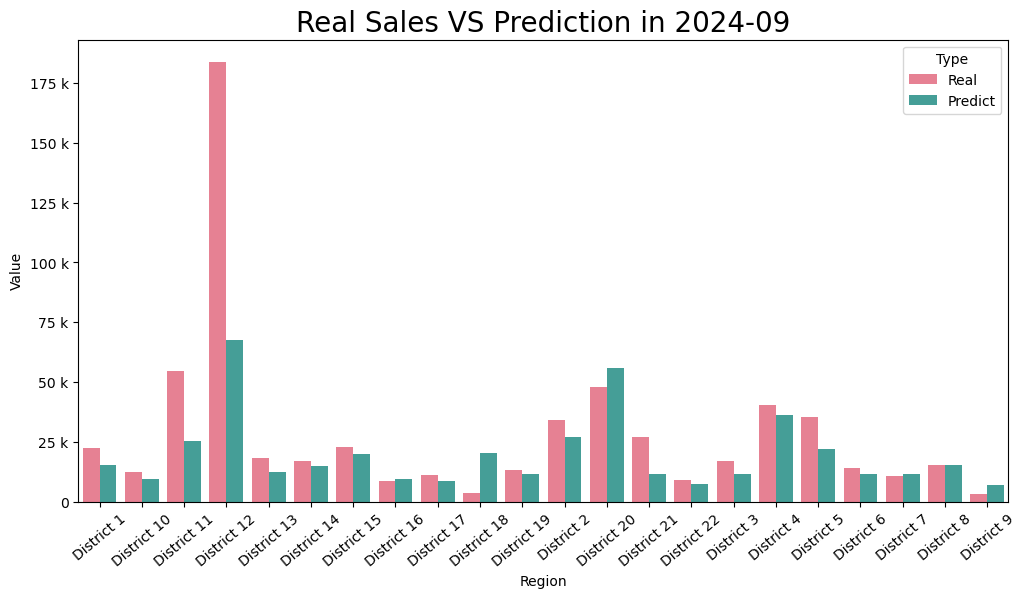

In [54]:

plt.figure(figsize=(12, 6)) 

#real_values = melted_submission[melted_submission['Type'] == 'Real']
#order = real_values.sort_values('Value')['Region'].tolist()

sns.barplot(data=melted_submission, x='Region', y='Value', hue='Type', palette='husl')

plt.xticks(rotation=40, fontsize=10)
plt.title('Real Sales VS Prediction in 2024-09',fontsize=20)

def func(x, pos):
    if x >= 1_000_000:
        return f'{x * 1e-6:,.0f} M'  
    elif x >= 1_000:
        return f'{x * 1e-3:,.0f} k'  
    return f'{x:,.0f}'   

plt.gca().yaxis.set_major_formatter(FuncFormatter(func))

plt.show()

In [55]:
melted_submission[melted_submission['Region']=='District 20']

,Region,Type,Value
12,District 20,Real,48056.55
37,District 20,Predict,56025.51
